In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import multiprocessing

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
sys.path.append(".")
from src.dc_smc import dc_smc 
from src.model import Model
from src.utils import resample

# Linear Gaussian HMM

In [165]:
#! matrix multiplication is wrong!
class LinearGaussian:
    def __init__(self, sigma0, A, B, C, D):
        self.sigma0 = sigma0
        self.mu0 = np.array(0.)
        self.A = A
        self.B = B
        self.C = C
        self.D = D
    def sample(self, nsamples, T):
        """sample x_i for i=1:(n+1) and y_i for i=1:n
        """
        x_vec = np.zeros((T+1, 1))
        y_vec = np.zeros((T, nsamples))
        
        # sample x0 from prior
        x_vec[0, :] = tfd.Normal(loc=self.mu0, scale=self.sigma0).sample(1)
        # sample iteratively
        for i in range(T):
            x_new, y_new = self.sample_once(x_vec[i, :], nsamples, i)
            x_vec[i+1, :] = x_new
            y_vec[i, :] = y_new
        
        return x_vec, y_vec
    
    def update_sample(self, x_vec, y_vec, T):
        """sample n more data
        """
        T_old, nsamples = y_vec.shape
        x_vec = np.append(x_vec, np.zeros((T, 1)), axis=0)
        y_vec = np.append(y_vec, np.zeros((T, nsamples)), axis=0)
        for i in range(T):
            x_new, y_new = self.sample_once(x_vec[i+T_old, :], nsamples, i)
            x_vec[i+1+T_old, :] = x_new
            y_vec[i+T_old, :] = y_new
        return x_vec, y_vec
            
    def sample_once(self, xt, nsamples, t):
        """sample for one time step
        """
        x_new = tf.math.multiply(self.A, xt) + \
            tf.math.multiply(self.B, tfd.Normal(loc=0, scale=1).sample(1)).numpy()
        y_new = tf.math.multiply(self.C, x_new) + \
            tf.math.multiply(self.D, tfd.Normal(loc=0, scale=1).sample(nsamples)).numpy()
        return x_new, y_new
            
    def log_gamma(self, x_vec, y_vec):
        """unnormalized log posterior
        """
        if x_vec.shape[0] == 1:
            log_p = tfd.Normal(loc=self.mu0, scale=self.sigma0).log_prob(x_vec[0, :])
            return log_p
        else:
            log_gamma = 0
            T, nsamples = y_vec.shape

            latent_mean = tf.math.multiply(self.C, x_vec[1:, :])[:, np.newaxis, :]
            log_lik = 0
            for t in range(T):
                log_lik += tfd.Normal(
                    loc=latent_mean[t, :], 
                    scale=self.D
                ).log_prob(y_vec[t, :].reshape(-1, 1))

            log_p = tfd.Normal(loc=self.mu0, scale=self.sigma0).log_prob(x_vec[0, :])
            for i in range(1, T):
                log_p += tfd.Normal(
                    loc=tf.math.multiply(self.A, x_vec[i-1, :]), 
                    scale=self.B
                ).log_prob(x_vec[i, :])

            return log_p + tf.reduce_sum(log_lik, axis=0)

In [216]:
# generate data
nsamples = 50 # n_y
T = 10
tf.random.set_seed(0)

# sigma0 = np.array([[1.]])
sigma0 = np.array(1.)
A = np.array([[0.8]])
B = np.ones((1, 1))
C = np.ones((1, 1))
D = np.ones((1, 1))

linear_hmm = LinearGaussian(sigma0, A, B, C, D)
x_vec, y_vec = linear_hmm.sample(nsamples, T)

In [217]:
# SIS
nx = 1000

x_pos = np.zeros((T+1, nx))
log_w = np.zeros_like(x_pos)
x_pos_resampled = np.zeros_like(x_pos)

# t=0
proposal_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1))
x_pos[0, :] = proposal_init.sample(nx)[:, 0]
log_w[0, :] = linear_hmm.log_gamma(x_pos[:1, :], None) - proposal_init.log_prob(x_pos[0, :])
x_pos_resampled[0, :] = resample(log_w[0, :], x_pos[0, :])

# t>=1
for t in range(T):
    # proposal: N(x_{t-1}, 1)
    proposal_t = tfd.Normal(loc=x_pos[t, :], scale=np.ones(1))
    x_pos[t+1, :] = proposal_t.sample(1)
    
    alpha_t = linear_hmm.log_gamma(x_pos[:(t+2), :], y_vec[:(t+1), :]) - \
        linear_hmm.log_gamma(x_pos[:(t+1), :], y_vec[:t, :]) - \
        proposal_t.log_prob(x_pos[t+1, :])
    log_w[t+1, :] = log_w[t, :] + alpha_t
    
    x_pos_resampled[t+1, :] = resample(log_w[t+1, :], x_pos[t+1, :])

    print("true x{}: {} estimate: {}".format(
        t+1, 
        x_vec[t+1, 0], 
        tf.reduce_mean(x_pos_resampled[t+1, :]).numpy()
    ))
    

true x1: 2.2232272715607047 estimate: 2.0194198238800296
true x2: 3.477558810809355 estimate: 3.394570652959467
true x3: 1.6074973498178333 estimate: 1.8315214954282502
true x4: 0.7157036784802129 estimate: 0.31924416522331583
true x5: 1.921818385403494 estimate: 1.331434560057252
true x6: 0.044118388399394526 estimate: 0.5539142400081464
true x7: 0.678292810046603 estimate: 0.6610092158361197
true x8: -0.6627111441898904 estimate: -0.59694124551972
true x9: -2.064314985832259 estimate: -2.722512701259994
true x10: -2.7020150856659293 estimate: -3.371547923705364


true x1: 2.2232272715607047 estimate: 2.0194198238800296


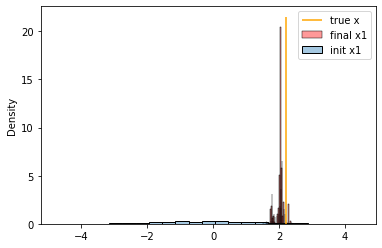

In [220]:
ind = 1

x_true = x_vec[ind, 0]

sns.histplot(x_pos_resampled[ind, :], stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(x_pos[ind, :], stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true, 0, ymax, color="orange", label="true x")
plt.legend()

print(
    f"true x{ind}:", x_true,
    "estimate:", tf.reduce_mean(x_pos_resampled[ind, :]).numpy()
)

# Non-linear Gaussian HMM

In [232]:
#! matrix multiplication is wrong!
class NonLinearGaussian(LinearGaussian):
    def __init__(self, sigma0, sigma_v, sigma_w):
        self.sigma0 = sigma0
        self.mu0 = np.zeros((1, 1))
        self.sigma_v = sigma_v
        self.sigma_w = sigma_w
            
    def _latent_mean(self, xt, t):
        return 0.5 * xt + 25 * xt / (1 + xt**2) + 8 * np.cos(1.2 * t)
    
    def sample_once(self, xt, nsample, t):
        x_new = self._latent_mean(xt, t) + \
            tfd.Normal(loc=0, scale=self.sigma_v).sample(1).numpy()
        y_new = 1/20 * x_new**2 + \
            tfd.Normal(loc=0, scale=self.sigma_w).sample(nsample).numpy()
        y_new = y_new[:, 0, 0]
        return x_new, y_new
            
    def log_gamma(self, x_vec, y_vec):
        """unnormalized log posterior
        """
        if x_vec.shape[0] == 1:
            log_p = tfd.Normal(loc=self.mu0, scale=self.sigma0).log_prob(x_vec[0, :])
            return log_p
        else:
            log_gamma = 0
            T, nsamples = y_vec.shape
            
        log_lik = 0
        print(x_vec[0, :].shape)
        for t in range(T):
            log_lik += tfd.Normal(
                loc=1/20 * x_vec[t, :]**2, 
                scale=self.sigma_w
            ).log_prob(y_vec[t, :].reshape(-1, 1))
            
        print(log_lik.shape)
            
        log_p = tfd.Normal(loc=self.mu0, scale=self.sigma0).log_prob(x_vec[0, :])
        for i in range(1, T):
            log_p += tfd.Normal(
                loc=self._latent_mean(x_vec[i-1, :], i), 
                scale=self.sigma_v
            ).log_prob(x_vec[i, :])
        return log_p + tf.reduce_sum(log_lik, axis=0)

In [233]:
sigma0 = np.array([[1.]])
sigma_v = np.array([[np.sqrt(10)]])
sigma_w = np.ones((1, 1))

T = 4

nonlinear_hmm = NonLinearGaussian(sigma0, sigma_v, sigma_w)
x_vec2, y_vec2 = nonlinear_hmm.sample(5, T)
x_vec2, y_vec2

(array([[ -1.25461279],
        [ -7.63270487],
        [ -4.12254132],
        [-13.59019874],
        [-16.33494576]]),
 array([[ 3.42280388,  3.61566817,  0.85544873,  2.85422368,  1.73017756],
        [ 0.37628916, -0.14458264,  1.21445049, -1.19760897,  0.82867261],
        [ 9.86588155,  9.75418413, 10.56175036,  8.84898799,  8.12426321],
        [13.82733685, 13.61978129, 14.48376415, 15.09307342, 12.65369417]]))

In [234]:
nonlinear_hmm.update_sample(x_vec2, y_vec2, 2)

(array([[ -1.25461279],
        [ -7.63270487],
        [ -4.12254132],
        [-13.59019874],
        [-16.33494576],
        [ -3.15132462],
        [ -7.84721332]]),
 array([[ 3.42280388,  3.61566817,  0.85544873,  2.85422368,  1.73017756],
        [ 0.37628916, -0.14458264,  1.21445049, -1.19760897,  0.82867261],
        [ 9.86588155,  9.75418413, 10.56175036,  8.84898799,  8.12426321],
        [13.82733685, 13.61978129, 14.48376415, 15.09307342, 12.65369417],
        [ 1.01766873,  0.91671581,  0.71761502,  1.15312831, -0.12688779],
        [ 0.2378908 ,  2.85793387,  1.5372123 ,  3.71941945,  3.88948906]]))

In [235]:
nonlinear_hmm.log_gamma(x_vec2, y_vec2)

(1,)
(5, 1)


<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-310.69712019]])>

# Hierarchical model

In [94]:
def hierarchical_targets(y, sigma0, eta, tau):
    def log_gamma_leaf(x):
        log_lik = tfd.Normal(loc=x, scale=eta).log_prob(y)
        log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 0])
        log_p += tfd.Normal(loc=x[:, 0], scale=tau).log_prob(x[:, 1:])
        return log_p
    
    def sample_x(nsamples):
        x_vec = np.zeros((nsapmles, 5))
        x_vec[:, 0] = tfd.Normal(loc=mu0, scale=sigma0).sample(nsamples)
        x_vec[:, 1:] = tfd.Normal(loc=x_vec[:, 0], scale=tau).sample((nsamples, x_vec.shape[1]-1))
        return x_vec
    
    def sample(nsamples, x_vec):
        y_vec = tfd.Normal(loc=x_vec[:, 1:], scale=eta).sample(nsamples)
        return y_vec
    